In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import re
import collections 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data gathering and data cleaning

In [2]:
data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/cmps242-spring18-hw5/train.csv')
test_data = pd.read_csv('/Users/mohsenkiskani/.kaggle/competitions/cmps242-spring18-hw5/test.csv')

In [3]:
def string_from_list(A):
    if len(A)>0:
        B = (" ".join(A)).lower()
        return re.sub('[^a-zA-z0-9\s]','',B)
    else:
        return None 

In [4]:
data['hashtags'] =  data['tweet'].apply((lambda x: re.findall(r"#(\w+)", x)))
test_data['hashtags'] =  test_data['tweet'].apply((lambda x: re.findall(r"#(\w+)", x)))

trump_tags = ["littlemarco", "makeamericagreatagain", "trump2016", "crookedhillary", "votetrumpsc", 
              "votetrump", "trumppence16", "trumppence2016", "americafirst", "votetrumpma", "neverhillary",
              "trump4president", "lightweightsenatormarcorubio", "trumpinstagram", "americagreatagain", 
              "trump4vets", "votetrumpmi", "votetrumphi", "votetrumpnh", "caucusfortrump", "trumpforpresident",
              "makeyoutubegreatagain", "votetrumpms", "votetrumpil", "votetrumpny", "votetrumpks", "trumppence2016",
             ]

trump_list   = []
clinton_list = []

for i in range(test_data.shape[0]):
    test_data['hashtags'][i] = [x.lower() for x in test_data['hashtags'][i]]
    
    for item in trump_tags:
        if item in test_data['hashtags'][i]:
            trump_list.append(i)
            break
        
    if "lovetrumpshate" in test_data['hashtags'][i] or "nevertrump" in test_data['hashtags'][i]:
        clinton_list.append(i)
        
trump_list   = set(trump_list)
clinton_list = set(clinton_list)

In [5]:
all_hashtags_trump   = []
all_hashtags_clinton = []

for i in range(data.shape[0]):
    data['hashtags'][i] = [x.lower() for x in data['hashtags'][i]]
    if data['handle'][i]=='realDonaldTrump':
        all_hashtags_trump.extend(data['hashtags'][i])
    else:
        all_hashtags_clinton.extend(data['hashtags'][i])

all_hashtags_trump_set = set(all_hashtags_trump)
all_hashtags_clinton_set = set(all_hashtags_clinton)
#print(all_hashtags_trump_set)
#print(all_hashtags_clinton_set)

In [6]:
data['handle']    = data['handle'].replace({'realDonaldTrump':1, 'HillaryClinton':0})

data['tweet']     = data['tweet'].apply((lambda x: re.sub(r"http\S+", 'urlurlurlurl', x)))
data['tweet']     = data['tweet'].apply(lambda x: x.lower())
data['tweet']     = data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
data['tweet']     = data['tweet'].apply((lambda x: re.sub(' +',' ',x)))
data['tweet']     = data['tweet'].apply((lambda x: re.sub(r'(\n+)(?=[A-Z])', r' ', x)))

test_data['tweet']     = test_data['tweet'].apply((lambda x: re.sub(r"http\S+", 'urlurlurlurl', x)))
test_data['tweet']     = test_data['tweet'].apply(lambda x: x.lower())
test_data['tweet']     = test_data['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
test_data['tweet']     = test_data['tweet'].apply((lambda x: re.sub(' +',' ',x)))
test_data['tweet']     = test_data['tweet'].apply((lambda x: re.sub(r'(\n+)(?=[A-Z])', r' ', x)))


all_tweets = pd.concat([data['tweet'], test_data['tweet']])

X       = data['tweet']
Y       = np.array(data['handle'].tolist())
X_test  = test_data['tweet']

X_train_bow_pd, X_val_bow_pd, Y_train_bow_pd, Y_val_bow_pd = train_test_split(X, Y,  test_size=0.1)

# Bag of word's model, feature selection

In [7]:
count_vec         = CountVectorizer()
tfidf_transformer = TfidfTransformer()

X_train_counts    = count_vec.fit_transform(X_train_bow_pd)
X_train_tfidf     = tfidf_transformer.fit_transform(X_train_counts)

X_val_counts      = count_vec.transform(X_val_bow_pd)
X_val_tfidf       = tfidf_transformer.transform(X_val_counts)

In [8]:
hyperVec                  = [1e6,1e5,1e4,1e3,1e2,1e1,1e0,1e-1,1e-2]
loss_dic_bow              = {}

for C in hyperVec:
    lf_tmp = LogisticRegression(C=C)
    lf_tmp.fit(X_train_tfidf, Y_train_bow_pd)
    y_val_predicted_tmp = lf_tmp.predict(X_val_tfidf)
    loss_dic_bow[C] = log_loss(y_pred = y_val_predicted_tmp, y_true =  Y_val_bow_pd)

    
C_optimal = min(loss_dic_bow, key=loss_dic_bow.get)

In [9]:
X_counts           = count_vec.fit_transform(X)
X_tfidf            = tfidf_transformer.fit_transform(X_counts)

X_test_counts      = count_vec.transform(X_test)
X_test_tfidf       = tfidf_transformer.transform(X_test_counts)

lf = LogisticRegression(C = C_optimal)
lf.fit(X_tfidf, Y)
Y_bow_predicted_test = lf.predict(X_test_tfidf)

#print(len(Y_bow_predicted_test))

In [10]:
X_tfidf_np      = X_tfidf.toarray()
X_test_tfidf_np = X_test_tfidf.toarray()
X_train_tfidf, X_val_tfidf, Y_train_tfidf, Y_val_tfidf = train_test_split(X_tfidf_np,\
                                                                          Y, test_size = 0.1, random_state = 42)
bow_dim_size    = X_tfidf.shape[1]
#print(X_test_tfidf_np.shape)
#print(X_tfidf_np.shape)

In [11]:
X_all = []
for i in range(X.shape[0]):
    X_all.append(X[i].split())
    
for i in range(X_test.shape[0]):
    X_all.append(X_test[i].split())

In [12]:
tweets         = all_tweets.tolist()
words          = " ".join(tweets)
words          = " ".join(words.split("\n")) 
words          = " ".join(words.split("\t"))
words          = " ".join(words.split("\xa0")).split()
whole_text     = " ".join(words)

count          = collections.Counter(words)
count_clean    = [(item, count[item]) for item in count if count[item]>1]
vocab_size     = len(count_clean)
num_words      = vocab_size+2 

dic = {}

for i in range(vocab_size):
    dic[count_clean[i][0]] = (i+1, count_clean[i][1])

In [13]:
def string_to_token_list(A):
    B      = A.strip().split(" ")
    output = []
    for item in B:
        if item in dic:
            output.append(dic[item][0])
        else:
            output.append(vocab_size + 1)
    return output

In [14]:
X_tokens       = X.apply(lambda x: string_to_token_list(x))
X_test_tokens  = X_test.apply(lambda x: string_to_token_list(x)) 

num_tokens     = [len(tokens) for tokens in X_tokens]
num_tokens     = np.array(num_tokens)
max_tokens     = int(np.max(num_tokens))

X_pad          = []
X_test_pad     = []

for item in X_tokens:
    n = len(item)
    X_pad.append([0]*(max_tokens-n) + item)

for item in X_test_tokens:
    n = len(item)
    X_test_pad.append([0]*(max_tokens-n) + item)
    
X_pad        = np.array(X_pad)
X_test_pad   = np.array(X_test_pad)
X_all_pad    = np.concatenate((X_pad , X_test_pad), axis=0)

In [15]:
X_train_pad, X_val_pad, Y_train_pad, Y_val_pad = train_test_split(X_pad, Y, test_size = 0.1, random_state = 42)

# Hyper parameter selection

In [146]:
lr                       = 1e-5

lstm_dropout_prob        = 0.5
lstm_forget_bias         = 1.0
reg_const                = 1.0
reg_const_bow            = 1.0

embedding_size           = 64
batch_size               = 128
lstm_out                 = 30

bow_hidden_layer_1_size  = 128
bow_hidden_layer_2_size  = 2

hidden_layer_1_size      = 32#lstm_out + bow_hidden_layer_2_size
hidden_layer_2_size      = 32#lstm_out + bow_hidden_layer_2_size

# Word embedding initialization 

In [147]:
from gensim.models import Word2Vec

model = Word2Vec(X_all, iter=100, min_count=2, size=embedding_size, workers=4)
#words = list(model.wv.vocab)
#print(words)
#print(model.wv.similar_by_word('makeamericagreatagain'))
#model.wv['trump'] 

In [148]:
embedding_matrix = np.zeros((1,embedding_size), np.float32)

for i in range(vocab_size):
    word             = count_clean[i][0]
    word_vec         = model.wv[word]
    embedding_matrix = np.vstack((embedding_matrix, word_vec))

embedding_matrix = np.vstack((embedding_matrix, 5* np.ones((1,embedding_size), np.float32)))

# Utility functions

In [149]:
def evaluate_test_data_set(filename, X_test_pad, X_test_tfidf_np, sess):
        test_size   = X_test_pad.shape[0]
        test_remain = batch_size - (test_size % batch_size) 
        X_test_pad      = np.concatenate((X_test_pad, np.zeros((test_remain, max_tokens), np.float32)), axis=0)
        X_test_tfidf_np = np.concatenate((X_test_tfidf_np, np.zeros((test_remain, bow_dim_size), np.float32)), axis=0)
        m = test_size // batch_size 
        pred_test_vals = np.empty((0, 2), np.float32)

        for i in range(m+1):
            input_test_batch      = X_test_pad[i * batch_size : (i+1) * batch_size, :]
            input_X_test_tfidf    = X_test_tfidf_np[i * batch_size : (i+1) * batch_size, :]
            test_preds_list  = sess.run([predictions], feed_dict = {X_bow : input_X_test_tfidf,
                                                                    X     : input_test_batch})
            pred_test_batch  = np.asarray(test_preds_list).reshape(batch_size, 2)
            pred_test_vals   = np.concatenate((pred_test_vals, pred_test_batch), axis=0)
            
        with open(filename,"w+") as outputfile:
            outputfile.write("id,realDonaldTrump,HillaryClinton\n")
            for j in range(test_size):
                if j in trump_list:
                    hillary = 0 
                    donald  = 1 
                elif j in clinton_list:
                    hillary = 1 
                    donald  = 0
                else:
                    hillary = pred_test_vals[j][1]
                    donald  = pred_test_vals[j][0]
                outputfile.write(str(j)+","+str(donald)+","+str(hillary)+"\n")

In [150]:
def get_batch(X, Y, X_tfidf, size):
    rdm         = np.random.choice(X.shape[0], size , replace = False)
    y1          = Y[rdm].reshape((size,1))
    y2          = (y1+1)%2
    Y_out       = np.concatenate((y1, y2), axis=1)
    X_out       = X[rdm,:]
    X_tfidf_out = X_tfidf[rdm,:] 
    return X_tfidf_out, X_out, Y_out

#### Look at 
https://github.com/bernhard2202/twitter-sentiment-analysis/blob/master/model/lstm.py

For a similar implementation

# Computational graph

In [151]:
with tf.device("/cpu:0"):
    
    tf.reset_default_graph()
    tf.set_random_seed(0)

    X_bow = tf.placeholder(tf.float32, shape=[batch_size, bow_dim_size])
    X     = tf.placeholder(tf.int32, shape=[batch_size, max_tokens])
    Y     = tf.placeholder(tf.float32, shape=[batch_size,2])
        
    embeddings     = tf.Variable(embedding_matrix)    
    embed          = tf.nn.embedding_lookup(embeddings, X)
    embed          = tf.unstack(embed, max_tokens, 1)
    
    lstm_cell                 = tf.contrib.rnn.BasicLSTMCell(lstm_out, forget_bias = lstm_forget_bias)
    lstm_cell                 = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=lstm_dropout_prob)
    lstm_output , lstm_state  = tf.contrib.rnn.static_rnn(lstm_cell, inputs=embed , dtype=tf.float32)
    
    outputs                   = tf.stack(lstm_output)
    outputs                   = tf.gather(outputs, max_tokens-1, axis=0)
    outputs                   = tf.reshape(outputs, [batch_size, lstm_out])
    lstm_final_output         = tf.reshape(outputs, [batch_size , lstm_out])
    
    bow_hidden_layer_1_output = tf.layers.dense(X_bow, bow_hidden_layer_1_size, 
                                               kernel_regularizer = tf.contrib.layers.l2_regularizer(reg_const_bow))
    bow_hidden_layer_2_output = tf.layers.dense(bow_hidden_layer_1_output, bow_hidden_layer_2_size, 
                                               kernel_regularizer = tf.contrib.layers.l2_regularizer(reg_const_bow))
    
    bow_concat_lstm           = tf.concat( [lstm_final_output, X_bow], axis=1)
    
    hidden_layer_1_output     = tf.layers.dense(bow_concat_lstm, hidden_layer_1_size,
                                                kernel_regularizer = tf.contrib.layers.l2_regularizer(reg_const) )
    hidden_layer_2_output     = tf.layers.dense(hidden_layer_1_output, hidden_layer_2_size,
                                                kernel_regularizer = tf.contrib.layers.l2_regularizer(reg_const))
    
    out_weight      = tf.Variable(tf.random_normal([hidden_layer_2_size, 2]))
    out_bias        = tf.Variable(tf.random_normal([2]))
    
    scores          = tf.nn.xw_plus_b(hidden_layer_2_output, out_weight,out_bias)
    predictions     = tf.nn.softmax(scores)
    
    losses          = tf.nn.softmax_cross_entropy_with_logits_v2(logits = scores,
                                                              labels = Y)
    loss            = tf.reduce_mean(losses)
    
    correct_pred    = tf.equal(tf.argmax(predictions, 1), tf.argmax(Y, 1))
    accuracy        = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    optimizer       = tf.train.AdamOptimizer(lr).minimize(loss)

# Running the computational graph

In [154]:
epochs           = 10000
display_epoch    = 10

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
allstr = "batchSize_" + str(batch_size) + "_embeddingSize_" + str(embedding_size) + \
         "_lstmOut_" + str(lstm_out) + "_bowSize2_" + str(bow_hidden_layer_2_size) + \
         "_hidden1_" + str(hidden_layer_1_size) + "_hidden2_" + str(hidden_layer_2_size) + "_time_"+ timestr
filename = "/Users/mohsenkiskani/Downloads/submissions/structred/lstm_bow_"+str(allstr)+".csv"

loss_val_vec     = []
accur_val_vec    = []
loss_train_vec   = []
accur_train_vec  = []
epoch_vec        = []

with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch in range(epochs):
            batch_bow_vals, batch_inputs, batch_labels = get_batch(X_train_pad, 
                                                                   Y_train_pad, 
                                                                   X_train_tfidf,
                                                                   batch_size)
            loss_train, accur_train, _ = sess.run([loss, accuracy, optimizer],
                                                  feed_dict = {X_bow : batch_bow_vals,
                                                               X     : batch_inputs,
                                                               Y     : batch_labels})
            
            batch_bow_vals, batch_inputs, batch_labels = get_batch(X_val_pad, 
                                                                   Y_val_pad, 
                                                                   X_val_tfidf,
                                                                   batch_size)
            
            loss_val, accur_val = sess.run([loss, accuracy],
                                           feed_dict = {X_bow : batch_bow_vals,
                                                        X     : batch_inputs,
                                                        Y     : batch_labels})
                
            loss_train_vec.append(loss_train)
            accur_train_vec.append(accur_train)
            loss_val_vec.append(loss_val)
            accur_val_vec.append(accur_val)
            epoch_vec.append(epoch)
            
            if epoch % display_epoch == 0:
                print("Epoch " +str(epoch) + ", Batch loss = ", 
                      "%.3f, " % loss_train , "training accuray = ",  "%.3f, " % accur_train, "val loss = ",
                      "%.3f, " % loss_val , "val accuray = ",  "%.3f, " % accur_val)
        
        evaluate_test_data_set(filename, X_test_pad, X_test_tfidf_np, sess)

Epoch 0, Batch loss =  1.019,  training accuray =  0.484,  val loss =  0.898,  val accuray =  0.562, 
Epoch 10, Batch loss =  0.870,  training accuray =  0.570,  val loss =  1.041,  val accuray =  0.477, 
Epoch 20, Batch loss =  0.962,  training accuray =  0.516,  val loss =  1.016,  val accuray =  0.492, 
Epoch 30, Batch loss =  0.872,  training accuray =  0.586,  val loss =  1.001,  val accuray =  0.492, 
Epoch 40, Batch loss =  0.960,  training accuray =  0.508,  val loss =  0.838,  val accuray =  0.578, 
Epoch 50, Batch loss =  1.003,  training accuray =  0.461,  val loss =  0.943,  val accuray =  0.516, 
Epoch 60, Batch loss =  1.031,  training accuray =  0.453,  val loss =  0.943,  val accuray =  0.508, 
Epoch 70, Batch loss =  0.845,  training accuray =  0.570,  val loss =  0.988,  val accuray =  0.477, 
Epoch 80, Batch loss =  0.903,  training accuray =  0.523,  val loss =  0.927,  val accuray =  0.508, 
Epoch 90, Batch loss =  1.000,  training accuray =  0.438,  val loss =  0.

Epoch 790, Batch loss =  0.557,  training accuray =  0.750,  val loss =  0.592,  val accuray =  0.648, 
Epoch 800, Batch loss =  0.574,  training accuray =  0.695,  val loss =  0.631,  val accuray =  0.609, 
Epoch 810, Batch loss =  0.570,  training accuray =  0.719,  val loss =  0.585,  val accuray =  0.680, 
Epoch 820, Batch loss =  0.515,  training accuray =  0.766,  val loss =  0.575,  val accuray =  0.703, 
Epoch 830, Batch loss =  0.567,  training accuray =  0.727,  val loss =  0.574,  val accuray =  0.719, 
Epoch 840, Batch loss =  0.587,  training accuray =  0.641,  val loss =  0.582,  val accuray =  0.664, 
Epoch 850, Batch loss =  0.552,  training accuray =  0.703,  val loss =  0.547,  val accuray =  0.734, 
Epoch 860, Batch loss =  0.542,  training accuray =  0.750,  val loss =  0.584,  val accuray =  0.688, 
Epoch 870, Batch loss =  0.547,  training accuray =  0.758,  val loss =  0.561,  val accuray =  0.711, 
Epoch 880, Batch loss =  0.509,  training accuray =  0.766,  val

Epoch 1580, Batch loss =  0.384,  training accuray =  0.875,  val loss =  0.433,  val accuray =  0.797, 
Epoch 1590, Batch loss =  0.376,  training accuray =  0.898,  val loss =  0.432,  val accuray =  0.836, 
Epoch 1600, Batch loss =  0.408,  training accuray =  0.844,  val loss =  0.477,  val accuray =  0.789, 
Epoch 1610, Batch loss =  0.383,  training accuray =  0.859,  val loss =  0.368,  val accuray =  0.898, 
Epoch 1620, Batch loss =  0.383,  training accuray =  0.852,  val loss =  0.451,  val accuray =  0.797, 
Epoch 1630, Batch loss =  0.394,  training accuray =  0.867,  val loss =  0.442,  val accuray =  0.844, 
Epoch 1640, Batch loss =  0.389,  training accuray =  0.867,  val loss =  0.458,  val accuray =  0.805, 
Epoch 1650, Batch loss =  0.326,  training accuray =  0.891,  val loss =  0.458,  val accuray =  0.781, 
Epoch 1660, Batch loss =  0.391,  training accuray =  0.875,  val loss =  0.400,  val accuray =  0.820, 
Epoch 1670, Batch loss =  0.320,  training accuray =  0

Epoch 2370, Batch loss =  0.225,  training accuray =  0.961,  val loss =  0.311,  val accuray =  0.930, 
Epoch 2380, Batch loss =  0.249,  training accuray =  0.953,  val loss =  0.339,  val accuray =  0.844, 
Epoch 2390, Batch loss =  0.296,  training accuray =  0.891,  val loss =  0.328,  val accuray =  0.891, 
Epoch 2400, Batch loss =  0.291,  training accuray =  0.898,  val loss =  0.351,  val accuray =  0.852, 
Epoch 2410, Batch loss =  0.267,  training accuray =  0.938,  val loss =  0.308,  val accuray =  0.883, 
Epoch 2420, Batch loss =  0.274,  training accuray =  0.922,  val loss =  0.304,  val accuray =  0.898, 
Epoch 2430, Batch loss =  0.268,  training accuray =  0.914,  val loss =  0.377,  val accuray =  0.812, 
Epoch 2440, Batch loss =  0.253,  training accuray =  0.906,  val loss =  0.359,  val accuray =  0.875, 
Epoch 2450, Batch loss =  0.290,  training accuray =  0.906,  val loss =  0.315,  val accuray =  0.875, 
Epoch 2460, Batch loss =  0.239,  training accuray =  0

Epoch 3160, Batch loss =  0.221,  training accuray =  0.938,  val loss =  0.242,  val accuray =  0.922, 
Epoch 3170, Batch loss =  0.191,  training accuray =  0.953,  val loss =  0.328,  val accuray =  0.867, 
Epoch 3180, Batch loss =  0.218,  training accuray =  0.945,  val loss =  0.289,  val accuray =  0.891, 
Epoch 3190, Batch loss =  0.195,  training accuray =  0.930,  val loss =  0.326,  val accuray =  0.867, 
Epoch 3200, Batch loss =  0.225,  training accuray =  0.922,  val loss =  0.306,  val accuray =  0.875, 
Epoch 3210, Batch loss =  0.248,  training accuray =  0.922,  val loss =  0.260,  val accuray =  0.883, 
Epoch 3220, Batch loss =  0.168,  training accuray =  0.969,  val loss =  0.340,  val accuray =  0.820, 
Epoch 3230, Batch loss =  0.247,  training accuray =  0.922,  val loss =  0.368,  val accuray =  0.820, 
Epoch 3240, Batch loss =  0.231,  training accuray =  0.914,  val loss =  0.294,  val accuray =  0.891, 
Epoch 3250, Batch loss =  0.229,  training accuray =  0

Epoch 3950, Batch loss =  0.161,  training accuray =  0.953,  val loss =  0.276,  val accuray =  0.906, 
Epoch 3960, Batch loss =  0.170,  training accuray =  0.945,  val loss =  0.235,  val accuray =  0.922, 
Epoch 3970, Batch loss =  0.157,  training accuray =  0.984,  val loss =  0.333,  val accuray =  0.859, 
Epoch 3980, Batch loss =  0.147,  training accuray =  0.977,  val loss =  0.271,  val accuray =  0.883, 
Epoch 3990, Batch loss =  0.177,  training accuray =  0.953,  val loss =  0.288,  val accuray =  0.891, 
Epoch 4000, Batch loss =  0.146,  training accuray =  0.969,  val loss =  0.280,  val accuray =  0.898, 
Epoch 4010, Batch loss =  0.153,  training accuray =  0.961,  val loss =  0.291,  val accuray =  0.922, 
Epoch 4020, Batch loss =  0.215,  training accuray =  0.930,  val loss =  0.264,  val accuray =  0.906, 
Epoch 4030, Batch loss =  0.174,  training accuray =  0.945,  val loss =  0.282,  val accuray =  0.914, 
Epoch 4040, Batch loss =  0.177,  training accuray =  0

Epoch 4740, Batch loss =  0.136,  training accuray =  0.969,  val loss =  0.197,  val accuray =  0.914, 
Epoch 4750, Batch loss =  0.175,  training accuray =  0.953,  val loss =  0.188,  val accuray =  0.945, 
Epoch 4760, Batch loss =  0.119,  training accuray =  0.977,  val loss =  0.275,  val accuray =  0.898, 
Epoch 4770, Batch loss =  0.144,  training accuray =  0.977,  val loss =  0.248,  val accuray =  0.875, 
Epoch 4780, Batch loss =  0.122,  training accuray =  0.969,  val loss =  0.186,  val accuray =  0.945, 
Epoch 4790, Batch loss =  0.102,  training accuray =  0.977,  val loss =  0.320,  val accuray =  0.883, 
Epoch 4800, Batch loss =  0.123,  training accuray =  0.953,  val loss =  0.266,  val accuray =  0.898, 
Epoch 4810, Batch loss =  0.104,  training accuray =  0.984,  val loss =  0.239,  val accuray =  0.914, 
Epoch 4820, Batch loss =  0.170,  training accuray =  0.945,  val loss =  0.247,  val accuray =  0.914, 
Epoch 4830, Batch loss =  0.096,  training accuray =  0

Epoch 5530, Batch loss =  0.096,  training accuray =  0.984,  val loss =  0.196,  val accuray =  0.930, 
Epoch 5540, Batch loss =  0.096,  training accuray =  1.000,  val loss =  0.216,  val accuray =  0.953, 
Epoch 5550, Batch loss =  0.098,  training accuray =  0.977,  val loss =  0.270,  val accuray =  0.906, 
Epoch 5560, Batch loss =  0.084,  training accuray =  0.969,  val loss =  0.208,  val accuray =  0.922, 
Epoch 5570, Batch loss =  0.129,  training accuray =  0.961,  val loss =  0.195,  val accuray =  0.930, 
Epoch 5580, Batch loss =  0.102,  training accuray =  0.984,  val loss =  0.245,  val accuray =  0.883, 
Epoch 5590, Batch loss =  0.094,  training accuray =  0.984,  val loss =  0.220,  val accuray =  0.922, 
Epoch 5600, Batch loss =  0.090,  training accuray =  0.984,  val loss =  0.234,  val accuray =  0.906, 
Epoch 5610, Batch loss =  0.105,  training accuray =  0.969,  val loss =  0.262,  val accuray =  0.906, 
Epoch 5620, Batch loss =  0.073,  training accuray =  0

Epoch 6320, Batch loss =  0.065,  training accuray =  0.992,  val loss =  0.216,  val accuray =  0.930, 
Epoch 6330, Batch loss =  0.071,  training accuray =  0.984,  val loss =  0.216,  val accuray =  0.922, 
Epoch 6340, Batch loss =  0.073,  training accuray =  0.992,  val loss =  0.143,  val accuray =  0.961, 
Epoch 6350, Batch loss =  0.070,  training accuray =  0.992,  val loss =  0.196,  val accuray =  0.922, 
Epoch 6360, Batch loss =  0.094,  training accuray =  0.977,  val loss =  0.220,  val accuray =  0.922, 
Epoch 6370, Batch loss =  0.058,  training accuray =  0.992,  val loss =  0.230,  val accuray =  0.938, 
Epoch 6380, Batch loss =  0.075,  training accuray =  0.992,  val loss =  0.201,  val accuray =  0.930, 
Epoch 6390, Batch loss =  0.073,  training accuray =  0.984,  val loss =  0.175,  val accuray =  0.945, 
Epoch 6400, Batch loss =  0.106,  training accuray =  0.984,  val loss =  0.213,  val accuray =  0.914, 
Epoch 6410, Batch loss =  0.079,  training accuray =  0

Epoch 7110, Batch loss =  0.048,  training accuray =  1.000,  val loss =  0.206,  val accuray =  0.914, 
Epoch 7120, Batch loss =  0.074,  training accuray =  0.984,  val loss =  0.158,  val accuray =  0.930, 
Epoch 7130, Batch loss =  0.063,  training accuray =  0.992,  val loss =  0.263,  val accuray =  0.898, 
Epoch 7140, Batch loss =  0.054,  training accuray =  1.000,  val loss =  0.239,  val accuray =  0.891, 
Epoch 7150, Batch loss =  0.059,  training accuray =  0.984,  val loss =  0.216,  val accuray =  0.938, 
Epoch 7160, Batch loss =  0.057,  training accuray =  0.992,  val loss =  0.167,  val accuray =  0.945, 
Epoch 7170, Batch loss =  0.041,  training accuray =  1.000,  val loss =  0.139,  val accuray =  0.953, 
Epoch 7180, Batch loss =  0.051,  training accuray =  1.000,  val loss =  0.173,  val accuray =  0.945, 
Epoch 7190, Batch loss =  0.068,  training accuray =  0.992,  val loss =  0.239,  val accuray =  0.922, 
Epoch 7200, Batch loss =  0.057,  training accuray =  1

Epoch 7900, Batch loss =  0.039,  training accuray =  0.992,  val loss =  0.206,  val accuray =  0.914, 
Epoch 7910, Batch loss =  0.049,  training accuray =  0.984,  val loss =  0.231,  val accuray =  0.906, 
Epoch 7920, Batch loss =  0.040,  training accuray =  1.000,  val loss =  0.158,  val accuray =  0.945, 
Epoch 7930, Batch loss =  0.050,  training accuray =  1.000,  val loss =  0.178,  val accuray =  0.930, 
Epoch 7940, Batch loss =  0.036,  training accuray =  1.000,  val loss =  0.247,  val accuray =  0.906, 
Epoch 7950, Batch loss =  0.046,  training accuray =  0.992,  val loss =  0.174,  val accuray =  0.930, 
Epoch 7960, Batch loss =  0.041,  training accuray =  0.984,  val loss =  0.209,  val accuray =  0.930, 
Epoch 7970, Batch loss =  0.035,  training accuray =  1.000,  val loss =  0.318,  val accuray =  0.867, 
Epoch 7980, Batch loss =  0.037,  training accuray =  1.000,  val loss =  0.223,  val accuray =  0.914, 
Epoch 7990, Batch loss =  0.050,  training accuray =  0

Epoch 8690, Batch loss =  0.044,  training accuray =  0.992,  val loss =  0.282,  val accuray =  0.922, 
Epoch 8700, Batch loss =  0.033,  training accuray =  1.000,  val loss =  0.187,  val accuray =  0.906, 
Epoch 8710, Batch loss =  0.027,  training accuray =  1.000,  val loss =  0.237,  val accuray =  0.906, 
Epoch 8720, Batch loss =  0.033,  training accuray =  1.000,  val loss =  0.235,  val accuray =  0.898, 
Epoch 8730, Batch loss =  0.046,  training accuray =  0.984,  val loss =  0.264,  val accuray =  0.883, 
Epoch 8740, Batch loss =  0.026,  training accuray =  1.000,  val loss =  0.204,  val accuray =  0.922, 
Epoch 8750, Batch loss =  0.036,  training accuray =  1.000,  val loss =  0.167,  val accuray =  0.930, 
Epoch 8760, Batch loss =  0.029,  training accuray =  1.000,  val loss =  0.294,  val accuray =  0.898, 
Epoch 8770, Batch loss =  0.036,  training accuray =  1.000,  val loss =  0.214,  val accuray =  0.914, 
Epoch 8780, Batch loss =  0.032,  training accuray =  0

Epoch 9480, Batch loss =  0.028,  training accuray =  1.000,  val loss =  0.238,  val accuray =  0.906, 
Epoch 9490, Batch loss =  0.021,  training accuray =  1.000,  val loss =  0.212,  val accuray =  0.906, 
Epoch 9500, Batch loss =  0.036,  training accuray =  0.992,  val loss =  0.166,  val accuray =  0.938, 
Epoch 9510, Batch loss =  0.032,  training accuray =  0.992,  val loss =  0.228,  val accuray =  0.898, 
Epoch 9520, Batch loss =  0.055,  training accuray =  0.992,  val loss =  0.146,  val accuray =  0.945, 
Epoch 9530, Batch loss =  0.017,  training accuray =  1.000,  val loss =  0.178,  val accuray =  0.938, 
Epoch 9540, Batch loss =  0.041,  training accuray =  0.992,  val loss =  0.264,  val accuray =  0.906, 
Epoch 9550, Batch loss =  0.014,  training accuray =  1.000,  val loss =  0.250,  val accuray =  0.906, 
Epoch 9560, Batch loss =  0.020,  training accuray =  1.000,  val loss =  0.172,  val accuray =  0.938, 
Epoch 9570, Batch loss =  0.016,  training accuray =  1

# Plotting the results

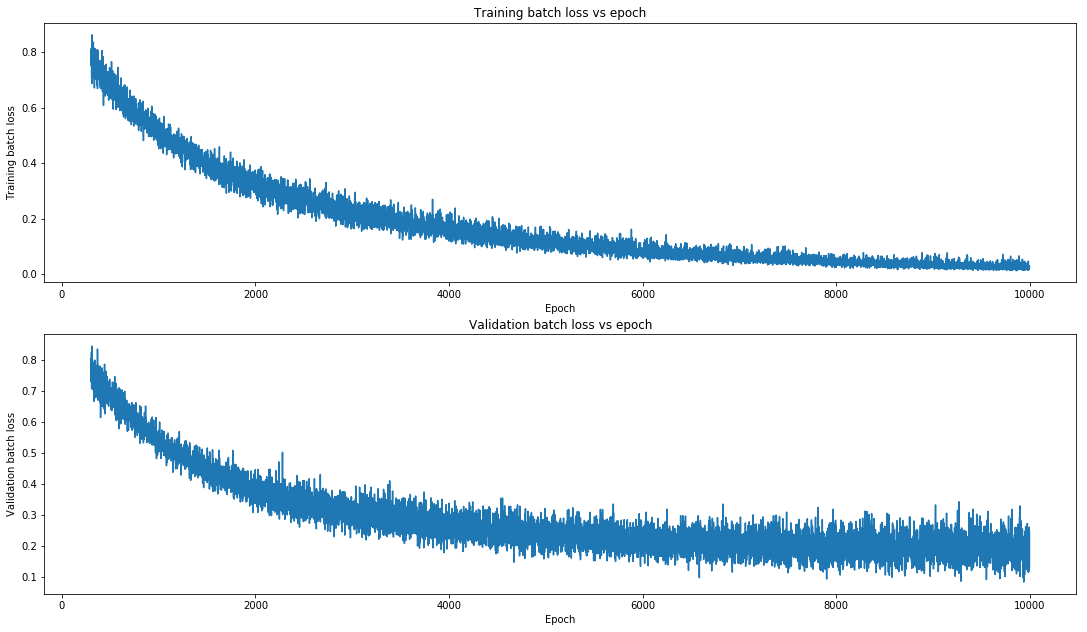

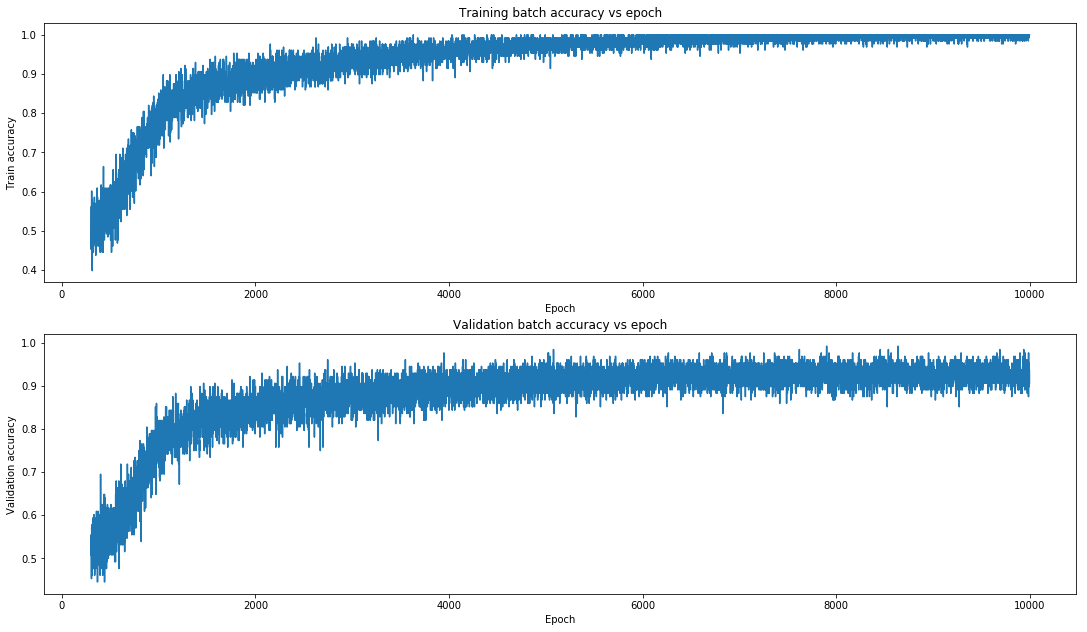

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt

plotting_parameter = 300

fig1, (ay1, ay2) = plt.subplots(2, 1)
ay1.plot(epoch_vec[plotting_parameter:], loss_train_vec[plotting_parameter:])
ay2.plot(epoch_vec[plotting_parameter:], loss_val_vec[plotting_parameter:])

fig2, (ay3, ay4) = plt.subplots(2, 1)
ay3.plot(epoch_vec[plotting_parameter:], accur_train_vec[plotting_parameter:])
ay4.plot(epoch_vec[plotting_parameter:], accur_val_vec[plotting_parameter:])

ay1.set_title('Training batch loss vs epoch')
ay1.set_xlabel('Epoch')
ay1.set_ylabel('Training batch loss')

ay2.set_title('Validation batch loss vs epoch')
ay2.set_xlabel('Epoch')
ay2.set_ylabel('Validation batch loss')

ay3.set_title('Training batch accuracy vs epoch')
ay3.set_xlabel('Epoch')
ay3.set_ylabel('Train accuracy')

ay4.set_title('Validation batch accuracy vs epoch')
ay4.set_xlabel('Epoch')
ay4.set_ylabel('Validation accuracy')

fig1.set_size_inches(18.5, 10.5)
fig1.savefig("/Users/mohsenkiskani/Downloads/submissions/structred/loss_"+timestr+".png", dpi=100)

fig2.set_size_inches(18.5, 10.5)
fig2.savefig("/Users/mohsenkiskani/Downloads/submissions/structred/accuracy_"+timestr+".png", dpi=100)
plt.show()

In [53]:
test_data['tweet'][5]

'kellyannepolls kellyanne you were fantastic on meetthepress today keep going i will win for the people make america great again'

In [156]:
loss_val_vec

[0.89821243,
 0.85832083,
 0.967569,
 1.0272363,
 0.9696244,
 1.0445185,
 1.0075109,
 1.0253726,
 0.99645746,
 1.0089962,
 1.0409911,
 1.0509422,
 0.9268191,
 0.93204427,
 1.0407597,
 0.9849317,
 0.9393016,
 0.9150517,
 1.0766394,
 0.8977665,
 1.0161712,
 0.8196515,
 0.9891337,
 0.9778171,
 0.9340654,
 1.085321,
 1.0524616,
 0.996031,
 0.9385838,
 0.9664972,
 1.0013951,
 0.9237012,
 0.9763791,
 0.9838004,
 0.96621156,
 1.0280716,
 1.079411,
 0.88553774,
 1.0584745,
 0.9378973,
 0.83817416,
 1.1112394,
 0.98311317,
 0.8893344,
 0.94265556,
 0.9555483,
 0.9812451,
 0.9281052,
 0.91257393,
 0.95072204,
 0.9433082,
 0.9201872,
 0.9316915,
 0.9242649,
 0.91812384,
 0.9388125,
 0.90751994,
 0.96497905,
 0.84622335,
 0.86785847,
 0.94315195,
 1.0161517,
 1.0226009,
 0.86603624,
 0.9329372,
 0.8744401,
 0.90020645,
 0.830003,
 0.9207852,
 0.947881,
 0.98842347,
 0.95132494,
 0.94301766,
 0.9795476,
 0.89751446,
 1.0179832,
 0.8825786,
 0.86630875,
 0.93034875,
 0.84062135,
 0.9272141,
 0.97476